### 数据预处理

先将 all_news.csv 中的文章去重，并保存为 processed_news.csv

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import math
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer

# 读取数据并去除重复文章
data = pd.read_csv('./data/all_news.csv')
data = data.drop_duplicates(['title','body']).reset_index(drop=True)
data.to_csv('./data/processed_news.csv')
data

,title,body,topic,id
0,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarner...,business,1
1,Dollar gains on Greenspan speech,The dollar has hit its highest level against t...,business,2
2,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuko...,business,3
3,High fuel prices hit BA's profits,British Airways has blamed high fuel prices fo...,business,4
4,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Domec...,business,5
...,...,...,...,...
2122,New consoles promise big problems,Making games for future consoles will require ...,tech,2220
2123,BT program to beat dialler scams,BT is introducing two initiatives to help beat...,tech,2221
2124,Be careful how you code,A new European directive could put software wr...,tech,2223
2125,US cyber security chief resigns,The man making sure US computer networks are s...,tech,2224


词形还原、去标点、分词、去除停用词

In [3]:
# 重新读取数据
data = pd.read_csv('./data/processed_news.csv', index_col=0)
lemmatizer = WordNetLemmatizer()

# 将文本全部转为小写
# 计算每个单词的词性，并依据词性对每个单词进行词形还原
def lemmatize_all(sentence):
    sentence = sentence.lower()
    words = []
    # 计算单词词性
    for word, tag in pos_tag(word_tokenize(sentence)):
        if tag.startswith('NN'):
            words.append(lemmatizer.lemmatize(word, pos='n'))
        elif tag.startswith('VB'):
            words.append(lemmatizer.lemmatize(word, pos='v'))
        elif tag.startswith('JJ'):
            words.append(lemmatizer.lemmatize(word, pos='a'))
        elif tag.startswith('R'):
            words.append(lemmatizer.lemmatize(word, pos='r'))
        else:
            words.append(lemmatizer.lemmatize(word))
    return ' '.join(words)

data['body'] = [lemmatize_all(i) for i in data['body']]

# 去除数字和标点符号等
def rid_of_specials(s):
    return re.sub('[^A-Za-z]+', ' ', s)
data['body'] = data['body'].astype(str).apply(rid_of_specials)

# 去除停用词
with open('./data/stopwords.txt', 'r', encoding='utf-8') as f:
	stop_words = f.readlines()  # 读取全部内容后，按行存储为list
stop_words = set(i.strip('\n') for i in stop_words)

def remove_sw(x):
    x = x.split(' ')
    return  ' '.join(z for z in x if z not in stop_words)
data['body'] = data['body'].apply(remove_sw)

data

,title,body,topic,id
0,Ad sales boost Time Warner profit,quarterly profit medium giant timewarner jump ...,business,1
1,Dollar gains on Greenspan speech,dollar hit high level euro almost three month ...,business,2
2,Yukos unit buyer faces loan claim,owner embattled russian oil giant yukos ask bu...,business,3
3,High fuel prices hit BA's profits,british airway blame high fuel price drop prof...,business,4
4,Pernod takeover talk lifts Domecq,share uk drink food firm ally domecq rise spec...,business,5
...,...,...,...,...
2122,New consoles promise big problems,make game future console require graphic artis...,tech,2220
2123,BT program to beat dialler scams,bt introduce two initiative help beat rogue di...,tech,2221
2124,Be careful how you code,new european directive could put software writ...,tech,2223
2125,US cyber security chief resigns,man make sure computer network safe secure res...,tech,2224


构建词典，可以去除低频词

In [4]:
# 构建词典
MIN_COUNT = 1
# 只使用出现次数大于等于MIN_COUNT的单词
# 此处设置为 1，可以修改
dic = dict()

for body in data['body']:
    for word in body.strip().split(' '):
        if word in dic:
            dic[word] += 1
        else:
            dic[word] = 1

vocab = []

for word, cnt in dic.items():
    if cnt >= MIN_COUNT:
        vocab.append(word)

vocab.sort()
print(len(vocab))
# 保存为 vocab.txt
with open('./data/vocab.txt', 'w') as f:
    print('\n'.join(vocab), file=f)

22779


计算TFIDF矩阵

In [5]:
"""
计算TFIDF矩阵
data为数据，id为data中文本序号的列名，body为data中文本的列名
返回文本数量*单词数量大小的TFIDF矩阵
"""
def get_tfidf(data, id, body):
    # 每个文章里的每个词一行
    split_words = data[body].str.split(' ', expand=True).stack().rename('word').reset_index()
    new_data = pd.merge(data[id], split_words, left_index=True, right_on='level_0')
    new_data = new_data[[id, 'word']]

    # 计算每个词在每篇文章中的TF
    def calc_TF(x):
        count = x.shape[0]
        x['TF'] = x.groupby('word')['word'].transform('count') / count
        return x
    new_data = new_data.groupby(id).apply(calc_TF)

    # 计算每个词在每篇文章中的IDF
    documents_count = len(data[id])
    tmp_df = new_data.loc[:,[id, 'word']].groupby('word').apply(lambda x: x.drop_duplicates().count())['word']
    tmp_df = tmp_df.apply(lambda x: math.log(documents_count/x))
    tmp_df.name = 'IDF'
    new_data = pd.merge(new_data, tmp_df, left_on='word', right_index=True).sort_index()

    # 计算每个词在每篇文章中的TF-IDF
    new_data['TF-IDF']=new_data['TF'].mul(new_data['IDF'])

    # 计算TF-IDF矩阵
    def calc_TFIDF(x):
        vec = np.zeros(len(vocab))
        for _, row in x.iterrows():
            try:
                idx = vocab.index(row['word'])
            except:
                continue
            vec[idx] = row['TF-IDF']
        return vec

    tfidf = new_data.groupby(id).apply(calc_TFIDF)
    tfidf = tfidf.sort_index()
    tfidf = np.vstack(tfidf)
    return tfidf

In [6]:
# 计算TFIDF矩阵并保存为 tfidf.npy
tfidf = get_tfidf(data, 'id', 'body')
print(tfidf)
print(tfidf.shape)
np.save('./data/tfidf.npy', tfidf)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(2127, 22779)


为HITS算法选择合适的文章相似度阈值

对于相似度大于0.2的两篇文章，认为是相似文章

In [7]:
from sklearn.decomposition import PCA

# 计算降维后的文章向量
tfidf = np.load('./data/tfidf.npy')
tfidf = normalize(tfidf, norm='l2') # 文章向量归一化
pca_tfidf = PCA(n_components=1000).fit_transform(tfidf) # 降维至1000维
pca_tfidf = normalize(pca_tfidf, norm='l2') # 文章向量再次归一化

NameError: name 'normalize' is not defined

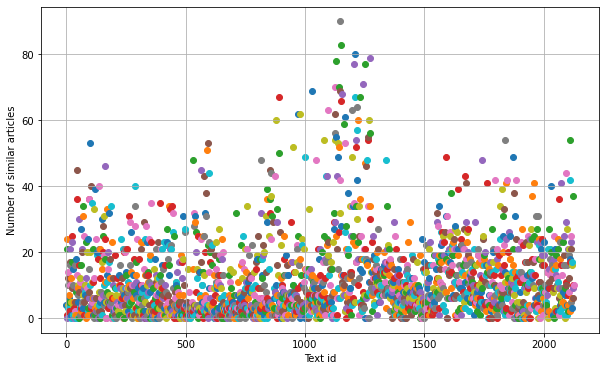

In [ ]:
"""
计算与编号为id的文章相似的文章，并以列表形式返回
阈值设为0.2可以使得相似文章数量集中在20以下
"""
def calc_sim_news(id):
    cos_sim = np.dot(pca_tfidf, pca_tfidf[id])
    return list(np.argwhere(cos_sim > 0.2).reshape((-1)))

fig = plt.figure(figsize=(10,6))
for i in range(tfidf.shape[0]):
    sim = calc_sim_news(i)
    plt.scatter(i, len(sim)-1)
plt.xlabel('Text id')
plt.ylabel('Number of similar articles')
plt.grid()
plt.show()

### 文章聚类与评价

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from scipy.optimize import linear_sum_assignment

# 读取TFIDF矩阵并降维至1000维
tfidf = np.load('./data/tfidf.npy')
tfidf = normalize(tfidf, norm='l2')
pca_tfidf = PCA(n_components=1000).fit_transform(tfidf)
pca_tfidf = normalize(pca_tfidf, norm='l2')
tfidf_2d = PCA(n_components=2).fit_transform(tfidf)

In [ ]:
# 读取原分类 Y
Y = pd.read_csv('./data/processed_news.csv', index_col=0)['topic']
Y = list(Y)
dic = {'business':0, 'entertainment':1, 'politics':2, 'sport':3, 'tech':4}

"""
评价按矩阵X进行KMeans聚类的Purity和F值
"""
def test(X):
    clf = KMeans(n_clusters=5).fit(X)
    plt.scatter(tfidf_2d[:, 0], tfidf_2d[:, 1], c=clf.labels_)

    # counts1[i,r]表示属于预定义类i且被分到第r个聚类的文档个数
    counts1 = np.zeros((5, clf.cluster_centers_.shape[0]), dtype=np.int32)

    # counts2[r]表示被分到第r个聚类的文档个数
    counts2 = np.zeros((clf.cluster_centers_.shape[0], ), dtype=np.int32)

    # counts3[i]表示属于预定义类i的文档个数
    counts3 = np.zeros((10,), dtype=np.int32)
    for i in Y:
        counts3[dic[i]] += 1

    # 计算 Purity
    for pre, now in zip(Y, clf.labels_):
        counts1[dic[pre], now] += 1
        counts2[now] += 1
    P = counts1.max(axis=0) / counts2
    Purity = (counts2 / len(Y) * P).sum()
    print('Purity =', Purity)

    # 计算 F值
    labels_old, labels_new = linear_sum_assignment(counts1, maximize=True)
    F = 0.0
    for i,r in zip(labels_old,labels_new):
        precision = counts1[i,r] / counts2[r]
        recall = counts1[i,r] / counts3[i]
        f = (2*recall*precision) / (precision+recall)
        F += counts3[i] / len(Y) * f
    print('F =', F)

按原 TFIDF 矩阵聚类

Purity = 0.8175834508697697
F = 0.8304922669535855


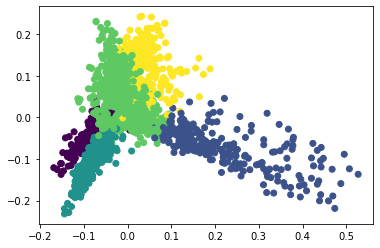

In [ ]:
test(tfidf)

按降维至1000维的文章向量聚类

Purity = 0.8251057827926658
F = 0.8289094063523672


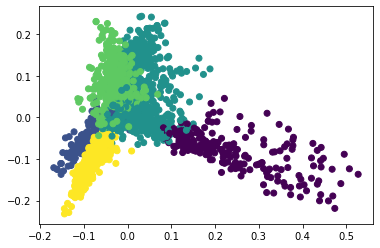

In [ ]:
test(pca_tfidf)

### 计算相似词

In [ ]:
import numpy as np
from sklearn.preprocessing import normalize
# 将原 TFIDF 矩阵转置，得到的矩阵每一行都是一个词向量
tfidf = np.load('./data/tfidf.npy').T
# 将词向量归一化
tfidf = normalize(tfidf, norm='l2')

# 计算相似度矩阵
sim_mat = np.matmul(tfidf, tfidf.T)

# 读取词典
with open('./data/vocab.txt', 'r') as f:
    vocab = [s.strip() for s in f.readlines()]

In [ ]:
syn_words = []
syn_score = []
for i in range(sim_mat.shape[0]):
    # 对于每个词 word，取与word相似度前六的词作为其相似词
    tmp = sim_mat[i].argpartition(-6)[-6:]
    syn_words.append(tmp)
    syn_score.append(sim_mat[i][tmp])
syn_words = np.vstack(syn_words) # 相似词
syn_score = np.vstack(syn_score) # 相似度
np.save('./data/synonym_words.npy',syn_words)
np.save('./data/synonym_score.npy',syn_score)

In [ ]:
with open('./data/synonym.txt', 'w') as f:
    for i in range(syn_words.shape[0]):
        word = vocab[i]
        s = word + ' : '
        for j in syn_words[i]:
            syn = vocab[j]
            if(syn!=word):
                s += syn + ' '
        s = s.strip()
        print(s, file=f)